## Project of Machine Learning

Purpose : Find the best roommate with a data of Wellbeing and lifestyle

for this project, we use the dataset from Kaggle : https://www.kaggle.com/c/wellbeing-and-lifestyle/data

we must define whether we use classification or regression


In [163]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import os


In [164]:
file_path = os.path.join(os.getcwd(), "Wellbeing_and_lifestyle_data.csv")

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("File not found")

print(df.describe())
print(df.head())



       FRUITS_VEGGIES  DAILY_STRESS  PLACES_VISITED   CORE_CIRCLE  \
count    15971.000000  15971.000000    15971.000000  15971.000000   
mean         2.922672      2.791685        5.233235      5.508296   
std          1.442739      1.367801        3.311847      2.840287   
min          0.000000      0.000000        0.000000      0.000000   
25%          2.000000      2.000000        2.000000      3.000000   
50%          3.000000      3.000000        5.000000      5.000000   
75%          4.000000      4.000000        8.000000      8.000000   
max          5.000000      5.000000       10.000000     10.000000   

       SUPPORTING_OTHERS  SOCIAL_NETWORK   ACHIEVEMENT      DONATION  \
count       15971.000000    15971.000000  15971.000000  15971.000000   
mean            5.616179        6.474047      4.000689      2.715171   
std             3.241937        3.086643      2.755912      1.851556   
min             0.000000        0.000000      0.000000      0.000000   
25%             3.

# Data exploration

## Types of Data
dtypes: float64(1), int64(19), object(4)

Object : Age, Gender, Timestamp, DAILY_STRESS

Float64 : Work_Life_Balance_Score

We must transform the Object into numerical values

For DAILY_STRESS => we had one data (1/1/0) who isn't INT on around 15K samples), result: we delete the row




In [165]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15971 entries, 0 to 15970
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                15971 non-null  object 
 1   FRUITS_VEGGIES           15971 non-null  int64  
 2   DAILY_STRESS             15971 non-null  int64  
 3   PLACES_VISITED           15971 non-null  int64  
 4   CORE_CIRCLE              15971 non-null  int64  
 5   SUPPORTING_OTHERS        15971 non-null  int64  
 6   SOCIAL_NETWORK           15971 non-null  int64  
 7   ACHIEVEMENT              15971 non-null  int64  
 8   DONATION                 15971 non-null  int64  
 9   BMI_RANGE                15971 non-null  int64  
 10  TODO_COMPLETED           15971 non-null  int64  
 11  FLOW                     15971 non-null  int64  
 12  DAILY_STEPS              15971 non-null  int64  
 13  LIVE_VISION              15971 non-null  int64  
 14  SLEEP_HOURS           

In [166]:
#GENDER
# onyl 2 values (Female and Male), so we translate this into 0 and 1

df["GENDER"] = df["GENDER"].map({"Female": 0, "Male": 1})

#Age
#We have 4 categories of Age :
#[less than 20, 21 to 35, 36 to 50, 51 or more]
# when it's possible, we take the half of age groupes
# for <20, we choose value : 16 and for 51 or more, we choose value : 70

# Convert AGE to numeric representation
age_mapping = {
    'Less than 20': 16,
    '21 to 35': 28,
    '36 to 50': 43,
    '51 or more': 70
}
df['AGE'] = df['AGE'].map(age_mapping)
df = df.drop(['Timestamp'], axis=1, inplace=False)
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15971 entries, 0 to 15970
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FRUITS_VEGGIES           15971 non-null  int64  
 1   DAILY_STRESS             15971 non-null  int64  
 2   PLACES_VISITED           15971 non-null  int64  
 3   CORE_CIRCLE              15971 non-null  int64  
 4   SUPPORTING_OTHERS        15971 non-null  int64  
 5   SOCIAL_NETWORK           15971 non-null  int64  
 6   ACHIEVEMENT              15971 non-null  int64  
 7   DONATION                 15971 non-null  int64  
 8   BMI_RANGE                15971 non-null  int64  
 9   TODO_COMPLETED           15971 non-null  int64  
 10  FLOW                     15971 non-null  int64  
 11  DAILY_STEPS              15971 non-null  int64  
 12  LIVE_VISION              15971 non-null  int64  
 13  SLEEP_HOURS              15971 non-null  int64  
 14  LOST_VACATION         

## PCA of the data



In [167]:
from sklearn.decomposition import PCA
X_train, X_test = train_test_split(df, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(X_train)
plt.figure(figsize=(8,6))


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [168]:
#Covariance Matrix
cov = np.cov(normalized_df)

print(cov)
print(cov.shape)

if cov.shape < (10,10):
    sns.heatmap(cov, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Covariance Heatmap")


[[ 1.22856600e-01  1.63792172e-02  8.57282019e-03 ...  6.48583938e-02
  -6.84682532e-05  3.74323141e-02]
 [ 1.63792172e-02  1.21017879e-01  4.29050009e-02 ... -3.60177107e-02
   3.81518742e-02 -2.21918960e-02]
 [ 8.57282019e-03  4.29050009e-02  1.20038290e-01 ...  1.29819311e-02
  -2.99421207e-02  9.04356159e-03]
 ...
 [ 6.48583938e-02 -3.60177107e-02  1.29819311e-02 ...  1.29501046e-01
  -4.33487557e-02  5.65727187e-02]
 [-6.84682532e-05  3.81518742e-02 -2.99421207e-02 ... -4.33487557e-02
   1.16272304e-01 -3.38961880e-02]
 [ 3.74323141e-02 -2.21918960e-02  9.04356159e-03 ...  5.65727187e-02
  -3.38961880e-02  1.00796907e-01]]
(12776, 12776)


In [169]:
#Correlation Matrix from Numpy

corrNP= np.corrcoef(normalized_df)
print(corrNP.shape)
if corrNP.shape < (10,10):
    sns.heatmap(corrNP, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")

(12776, 12776)


(23, 23)


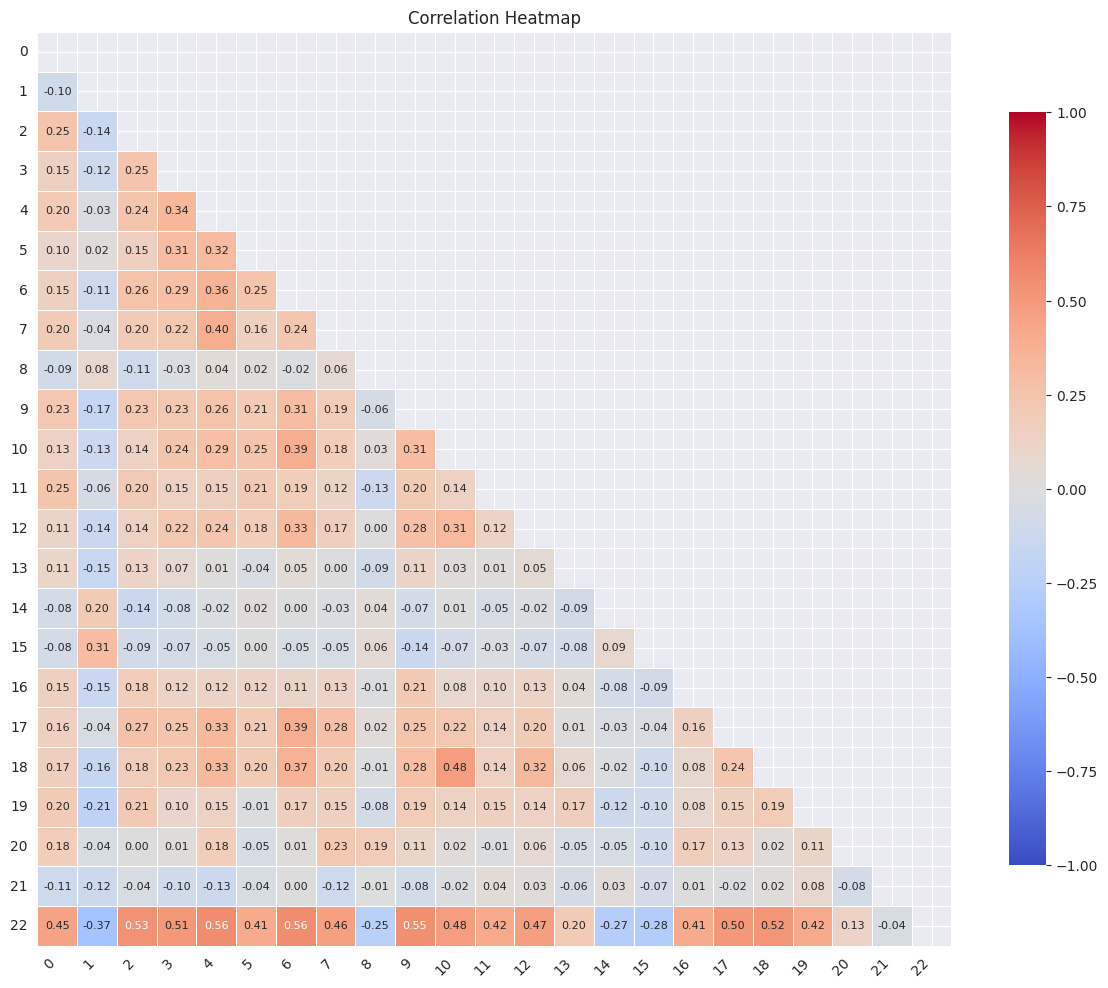

In [170]:
#Correlation Matrix from Pandas

corrPD = pd.DataFrame(normalized_df).corr()
print(corrPD.shape)
if corrPD.shape <= (23, 23):
    mask = np.triu(np.ones_like(corrPD, dtype=bool))
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        corrPD,
        mask=mask,
        annot=True,
        annot_kws={"size": 8},
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        fmt=".2f",
        linewidths=0.5,
        linecolor="white",
        square=True,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Correlation Heatmap")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()


In [171]:


X_test = scaler.transform(X_test)
pca = PCA(n_components=8)
X_train = pca.fit_transform(normalized_df)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

print(explained_variance)
print(sum(explained_variance))


[0.17387086 0.11178575 0.10129109 0.07776802 0.06131803 0.05203576
 0.04451781 0.0417142 ]
0.664301521322969


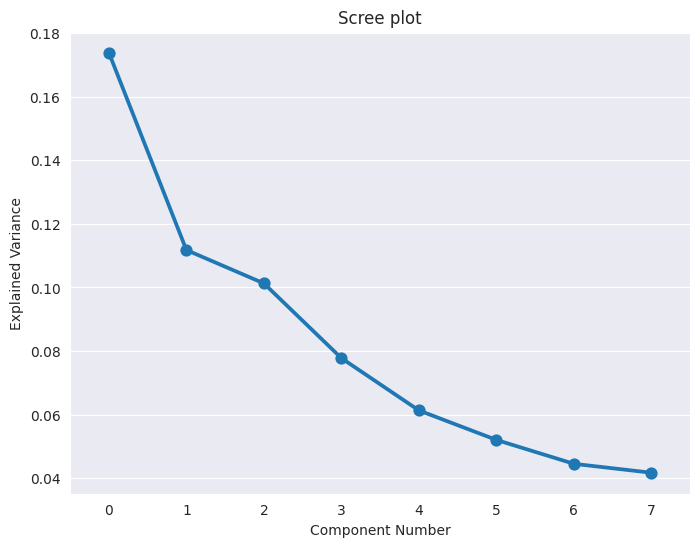

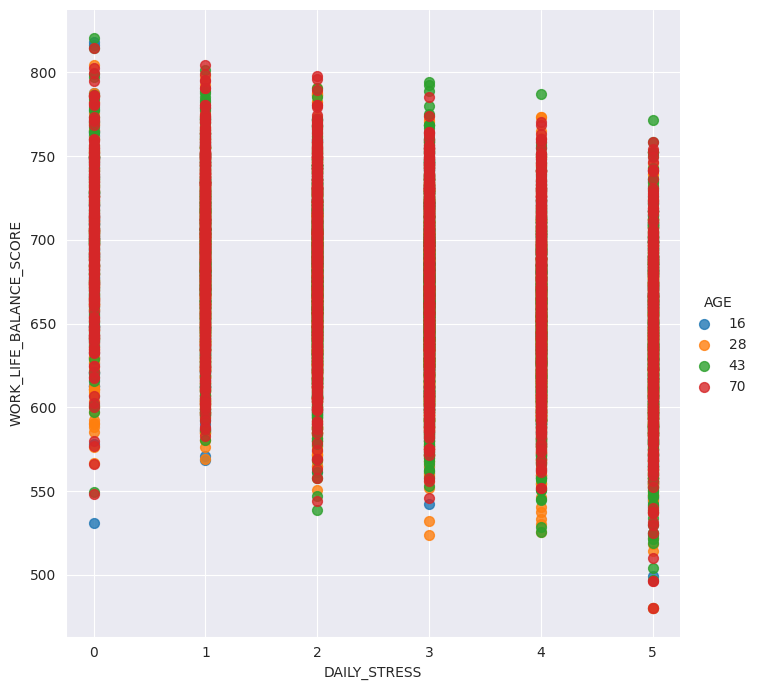

Text(0.5, 1.0, 'Variable factor map')

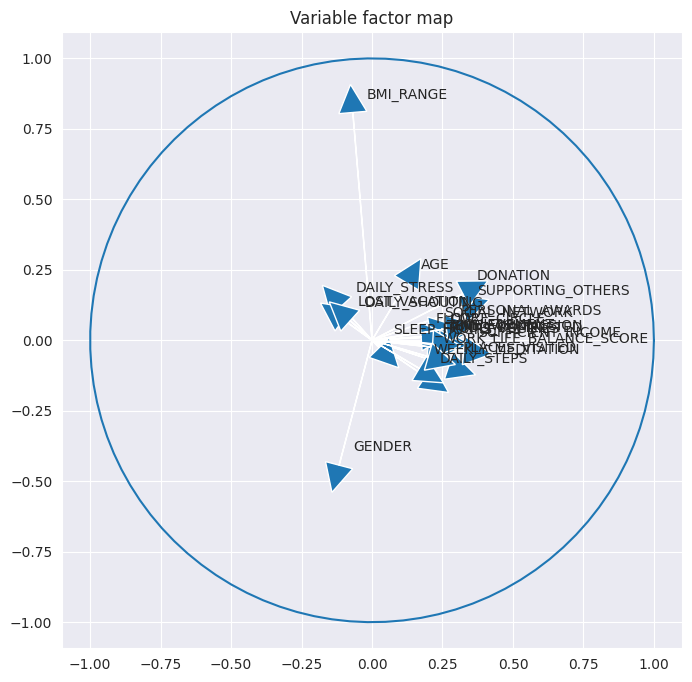

In [172]:
ind = np.arange(0, pca.n_components_)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

# Show the points in terms of the first two PCs
g = sns.lmplot(
    x='DAILY_STRESS',
    y='WORK_LIFE_BALANCE_SCORE',
    hue='AGE',
    data=df,
    fit_reg=False,              # or: line_kws={'linewidth': 0} if needed
    height=7,                   # replaces size=7
    scatter_kws={'s': 50}       # control point size instead of scatter=True
)

plt.show()

# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             df.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')


(8, 23)


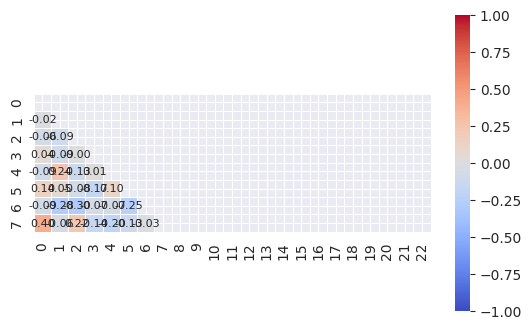

In [173]:

mask = np.triu(np.ones_like(pca.components_, dtype=bool))  # upper triangle mask

sns.heatmap(
    pca.components_,
    mask=mask,
    annot=True,
    annot_kws={"size": 8},
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    fmt=".2f",
    linewidths=0.5,
    linecolor="white",
    square=True,
    cbar_kws={"shrink": 0.8}
)

print(pca.components_.shape)